In [1]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import Datasets.ModelData as md
from session import *
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
from LR_Schedule.cos_anneal import CosAnneal
import matplotlib.pyplot as plt
import arff

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
idtohand = {0: "Empty Hand",
            1: "One pair",
            2: "Two pair",
            3: "Three of a kind",
            4: "Straight",
            5: "Flush",
            6: "Full house",
            7: "Four of a kind",
            8: "Straight flush",
            9: "Royal flush" }

num_classes = 10

idtosuit = {0: "Hearts", 1: "Spades", 2: "Diamonds", 3: "Clubs"}
idtorank = {0: "Ace", 
            1: "2", 
            2: "3", 
            3: "4", 
            4: "5", 
            5: "6", 
            6: "7", 
            7: "8", 
            8: "9", 
            9: "10", 
            10: "Jack", 
            11: "Queen", 
            12: "King"}

In [4]:
class PokerHandDataset(Dataset):
    def __init__(self, file, tfm=None, percentage=1, balanced=False):
        self.hands, self.labels = self.parse_csv(file, percentage)
        self.tfm = tfm
                  
        if balanced:
            counts = np.zeros(num_classes)

            for label in self.labels:
                counts[label] += 1

            class_weights = (len(self.labels) / counts)**.7
            
            fig, ax = plt.subplots()
            ax.bar(idtohand.values(), counts)
            ax.set_xticklabels(idtohand.values(), rotation='vertical', fontsize=10)
            ax.set_xlabel("Class Label")
            ax.set_ylabel("Number of Examples")
            
            fig.savefig('histogram.png', bbox_inches = "tight")
            
            fig1, ax1 = plt.subplots()
            ax1.bar(idtohand.values(), class_weights)
            
            fig2, ax2 = plt.subplots()
            ax2.bar(idtohand.values(), [w * c for w, c in zip(class_weights, counts)])

            instance_weights = np.zeros(len(self.labels))

            for idx, label in enumerate(self.labels):
                instance_weights[idx] = class_weights[label]

            self.sampler = torch.utils.data.sampler.WeightedRandomSampler(instance_weights, len(instance_weights))
        else:
            self.sampler = None
       
    @staticmethod
    def parse_csv(file, percentage=1):
        df = pd.read_csv(file, header=None)
        xs = df[df.columns[0:10]]
        labels = np.array(df[df.columns[-1]])
        
        hands = []
        for hand in xs.values:
            hand = np.array(hand).reshape((5,2)) - 1
            hand = hand[hand[:,1].argsort()]
            hands.append(hand)
            
        hands = np.array(hands)
        
        if percentage < 1:
            idxs = np.random.choice(len(xs), int(len(xs) * percentage), replace=False)
            hands = hands[idxs]
            labels = labels[idxs]
            
        return hands, labels
        
    @staticmethod
    def make_tensor(hand):
        hand_tensor = torch.zeros((4,13)) - 1
        for card in hand:       
            hand_tensor[card[0], card[1]] = 1
        return hand_tensor.unsqueeze(0)
    
    @staticmethod
    def make_one_hot(label):
        tensor = torch.zeros(10)
        tensor[label] = 1
        return tensor
    
    def save_arff(self, file_name):
        data = np.concatenate((self.hands.reshape((-1, 10)), self.labels.reshape(-1, 1)), 1)
        
        cols = ["SuitCard1", "RankCard1", 
                "SuitCard2", "RankCard2", 
                "SuitCard3", "RankCard3", 
                "SuitCard4", "RankCard4",
                "SuitCard5", "RankCard5",
                "Hand"]

        df = pd.DataFrame(data, columns=cols)

        arff.dump(file_name, df.values, names=df.columns)
        
    
    def __len__(self): return len(self.hands)

    def __getitem__(self, i):
        hand, label = self.hands[i], self.labels[i]
        x, y = self.make_tensor(hand), label
        
        if self.tfm is not None:
            x = self.tfm.transform_x(x)
            
        return x, y

In [5]:
class SuitShiftTransform():
    def transform_x(self, hand):
        return hand[:,torch.randperm(4)]

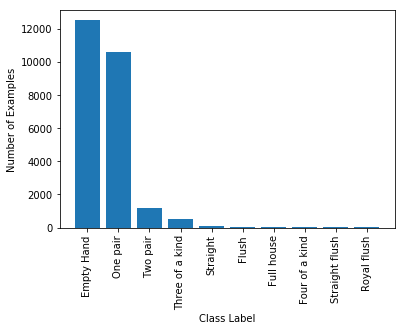

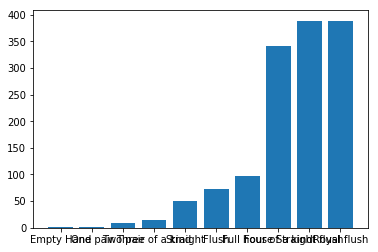

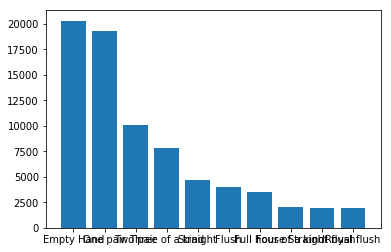

In [6]:
data_path = Path("./Datasets/PokerHands")

# With reweighting and augmentation
train_dataset = PokerHandDataset(data_path/'training.csv', tfm=SuitShiftTransform(), balanced=True)  

# Without reweighting and augmentation
# train_dataset = PokerHandDataset(data_path/'training.csv')

val_dataset = PokerHandDataset(data_path/'testing.csv', percentage=.05)
test_dataset = PokerHandDataset(data_path/'testing.csv')

In [7]:
data = md.ModelData({'train': train_dataset}, 32)
val_data = md.ModelData({'val': val_dataset, 'test': test_dataset}, 256)

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = nn.Conv2d(1, 32, (4,1))       
        self.conv2 = nn.Conv2d(1, 32, (1,13))
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=.2)
        self.fc = nn.Linear(32*4 + 32*13, 64)
        self.relu2 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=.1)
        self.fc2 = nn.Linear(64, num_classes)      
        
    def forward(self, x, log=False):
        x_1 = self.conv1(x)
        x_2 = self.conv2(x)
        x = torch.cat([x_1.view(x_1.size(0), -1), x_2.view(x_2.size(0), -1)], dim=1)
        x = self.drop(x)
        x = self.relu(x)
        if log: print(x[0])
        x = self.fc(x)
        # x = self.drop2(x)
        x = self.relu2(x)
        if log: print(x[0])
        x = self.fc2(x)
        if log: print(x[0])
        return x

In [9]:
model = Network()

In [10]:
class PokerHandAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]

    def reset(self):
        self.num_correct = 0
        self.count = 0
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]
        
    def accuracy(self): 
        return self.num_correct / self.count

    def update(self, actn, label, log=False):   
        actn = F.log_softmax(actn, dim=1)
        vals, preds = torch.max(actn, 1)
        if log: print("Max  :", preds)
        if log: print("Preds: ", preds)    
        if log: print("GT   : ", label)
        self.num_correct += torch.sum(preds == label).item()
        if log: print("Num Correct: ", self.num_correct)
        self.count += label.shape[0]
        
        for lab, pred in zip(label, preds):
            self.confusion[lab][pred] += 1
            
    def plot_confusion_matrix(self,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = np.array(self.confusion)
        fig, ax = plt.subplots(figsize=(12,12))
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        tick_marks = [val for key, val in idtohand.items()]
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(tick_marks, rotation='vertical', fontsize=12)
        
        ax.set_yticks(np.arange(10))
        ax.set_yticklabels(tick_marks, fontsize=12)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        
        return fig, ax

In [11]:
criterion = nn.CrossEntropyLoss()
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-2)

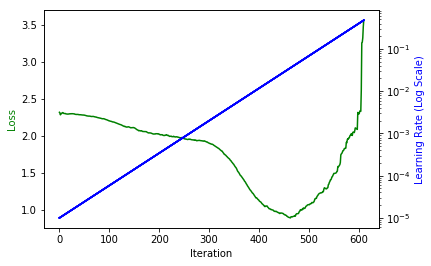

In [12]:
# To find a suitible learning rate
lr_find(sess, data['train'], start_lr=1e-5)

In [13]:
# Choose 1e-2 visually from the graph
sess.set_lr(1e-2)

In [14]:
accuracy = PokerHandAccuracy()
validator = Validator(val_data['val'], accuracy)
lr_schedule = CosAnneal(len(data['train']), lr_min=1e-5, T_mult=2)
schedule = TrainingSchedule(data['train'], [lr_schedule, validator])

In [15]:
sess.train(schedule, 63)

Training Loss: 0.113358  Validaton Loss: 0.049063 Validation Accuracy: 0.986680


Training Loss: 0.060071  Validaton Loss: 0.028528 Validation Accuracy: 0.991780


Training Loss: 0.026085  Validaton Loss: 0.017371 Validation Accuracy: 0.995660


Training Loss: 0.061473  Validaton Loss: 0.020786 Validation Accuracy: 0.994200


Training Loss: 0.030351  Validaton Loss: 0.009953 Validation Accuracy: 0.997700


Training Loss: 0.009490  Validaton Loss: 0.006640 Validation Accuracy: 0.998880


Training Loss: 0.006694  Validaton Loss: 0.007268 Validation Accuracy: 0.998780


Training Loss: 0.050882  Validaton Loss: 0.036026 Validation Accuracy: 0.990300


Training Loss: 0.028064  Validaton Loss: 0.013407 Validation Accuracy: 0.996860


Training Loss: 0.021001  Validaton Loss: 0.007132 Validation Accuracy: 0.999220


Training Loss: 0.012774  Validaton Loss: 0.013381 Validation Accuracy: 0.997160


Training Loss: 0.010338  Validaton Loss: 0.007610 Validation Accuracy: 0.999300


Training Loss: 0.014094  Validaton Loss: 0.006648 Validation Accuracy: 0.999740


Training Loss: 0.002568  Validaton Loss: 0.006666 Validation Accuracy: 0.999720


Training Loss: 0.003770  Validaton Loss: 0.006937 Validation Accuracy: 0.999740


Training Loss: 0.026578  Validaton Loss: 0.015536 Validation Accuracy: 0.998420


Training Loss: 0.029979  Validaton Loss: 0.035629 Validation Accuracy: 0.990660


Training Loss: 0.030190  Validaton Loss: 0.023862 Validation Accuracy: 0.996880


Training Loss: 0.024221  Validaton Loss: 0.029176 Validation Accuracy: 0.993560


Training Loss: 0.026482  Validaton Loss: 0.014746 Validation Accuracy: 0.998540


Training Loss: 0.024649  Validaton Loss: 0.012911 Validation Accuracy: 0.998580


Training Loss: 0.015157  Validaton Loss: 0.011260 Validation Accuracy: 0.999240


Training Loss: 0.009683  Validaton Loss: 0.012682 Validation Accuracy: 0.998860


Training Loss: 0.006360  Validaton Loss: 0.011129 Validation Accuracy: 0.999260


Training Loss: 0.009428  Validaton Loss: 0.009941 Validation Accuracy: 0.999660


Training Loss: 0.003812  Validaton Loss: 0.010491 Validation Accuracy: 0.999420


Training Loss: 0.007033  Validaton Loss: 0.010125 Validation Accuracy: 0.999640


Training Loss: 0.004309  Validaton Loss: 0.010871 Validation Accuracy: 0.999640


Training Loss: 0.002678  Validaton Loss: 0.010503 Validation Accuracy: 0.999640


Training Loss: 0.005234  Validaton Loss: 0.010416 Validation Accuracy: 0.999660


Training Loss: 0.003802  Validaton Loss: 0.010300 Validation Accuracy: 0.999660


Training Loss: 0.034160  Validaton Loss: 0.026724 Validation Accuracy: 0.995440


Training Loss: 0.027682  Validaton Loss: 0.056162 Validation Accuracy: 0.991120


Training Loss: 0.028471  Validaton Loss: 0.026153 Validation Accuracy: 0.995520


Training Loss: 0.026037  Validaton Loss: 0.017134 Validation Accuracy: 0.997820


Training Loss: 0.036800  Validaton Loss: 0.014008 Validation Accuracy: 0.998300


Training Loss: 0.016285  Validaton Loss: 0.025837 Validation Accuracy: 0.996820


Training Loss: 0.032212  Validaton Loss: 0.027765 Validation Accuracy: 0.997820


Training Loss: 0.036079  Validaton Loss: 0.026388 Validation Accuracy: 0.997640


Training Loss: 0.033618  Validaton Loss: 0.022193 Validation Accuracy: 0.999540


Training Loss: 0.024038  Validaton Loss: 0.023746 Validation Accuracy: 0.998600


Training Loss: 0.006382  Validaton Loss: 0.022035 Validation Accuracy: 0.999360


Training Loss: 0.009757  Validaton Loss: 0.023543 Validation Accuracy: 0.999240


Training Loss: 0.028551  Validaton Loss: 0.032492 Validation Accuracy: 0.996820


Process Process-363:
Process Process-364:
Process Process-362:
Process Process-361:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1234eeb00>)

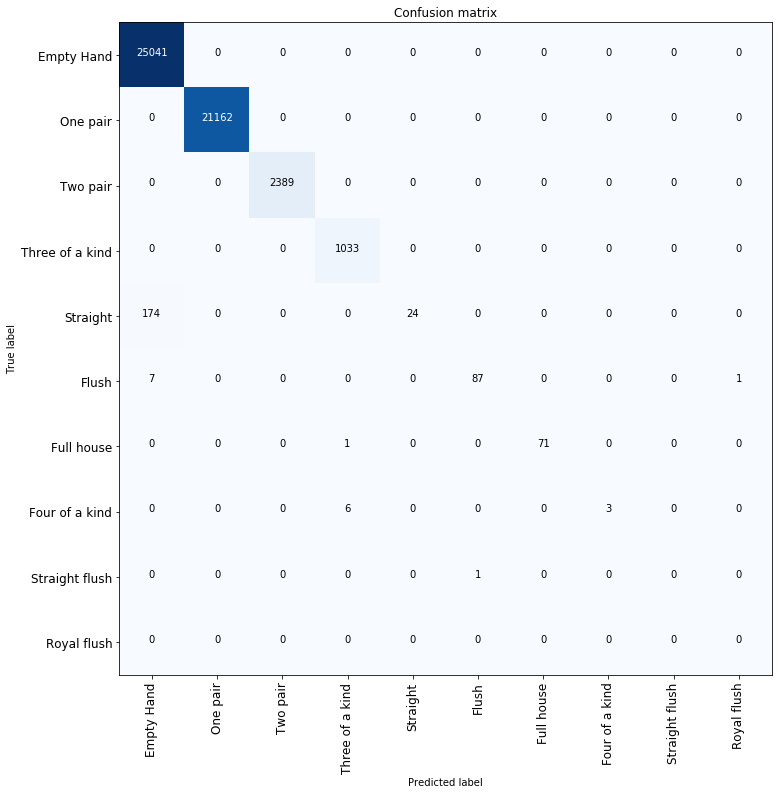

In [148]:
# here is a confusion matrix on the training set
accuracy.plot_confusion_matrix()

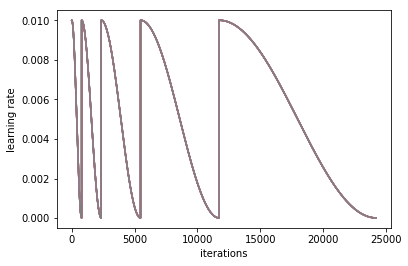

In [103]:
# This is how the learning rate changes during training
lr_schedule.plot()

In [100]:
sess.save("PokerHand-99.99")

Training Loss: 0.000000  Validaton Loss: 0.019289 Validation Accuracy: 0.999702


(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1227e7160>)

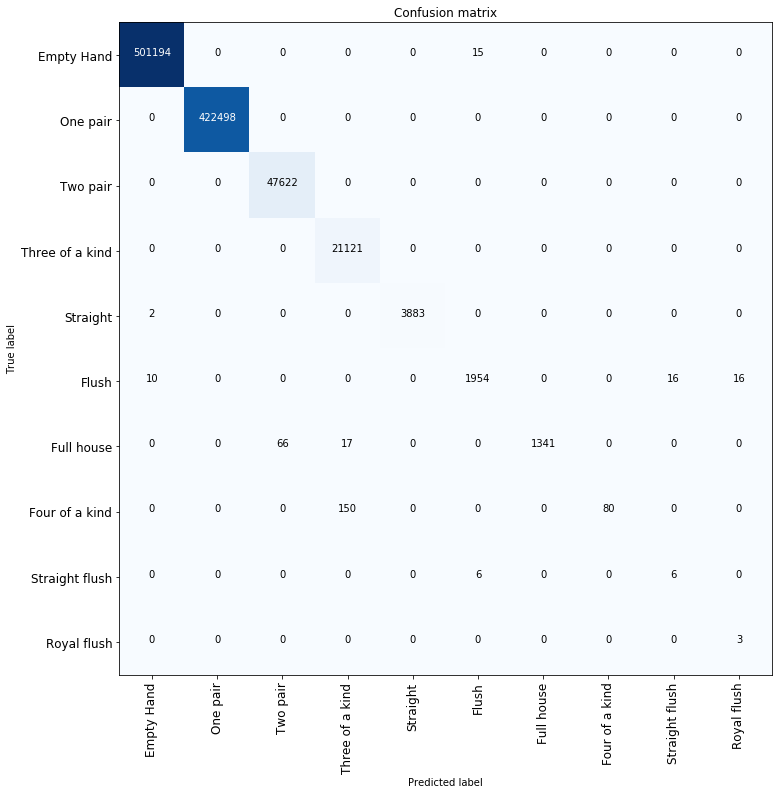

In [189]:
# And finally, the performance on the test set
t_accuracy = PokerHandAccuracy()
t_validator = Validator(val_data['test'], t_accuracy)
t_validator.on_epoch_end(sess, LossMeter())
t_accuracy.plot_confusion_matrix()